## SEC-SAXS Frames and Ext Guinier

In [5]:
import pandas as pd
import os
import sys,math

from scipy import optimize
from scipy import special
from scipy.optimize import curve_fit
from scipy import stats 

import numpy as np
import glob

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from collections import OrderedDict
from collections import defaultdict

import re

import seaborn as sns
import pickle


In [4]:
import pickle

class DataProcessor_forSECSAXS:
    def __init__(self, base_dir, save_dir):
        self.base_dir = base_dir
        self.save_dir = save_dir
        self.dataframes = []

    def extract_last_number(self, file_name):
        match = re.search(r'(\d+)(?!.*\d)', file_name)
        return match.group(1) if match else None

    def get_concentration(self, file_name):
        if '0_5mg_mL' in file_name:
            return '0.5mg/mL'
        elif '1_5mg_mL' in file_name:
            return '1.5mg/mL'
        elif '1mg_mL' in file_name:
            return '1.0mg/mL'
        elif '2mg_mL' in file_name:
            return '2.0mg/mL'
        elif '3mg_mL' in file_name:
            return '3.0mg/mL'
        elif '3mg_ml' in file_name:
            return '1.7mg/mL'
        elif '4mg_ml' in file_name:
            return '2.3mg/mL'
        elif '5mg_ml' in file_name:
            return '2.8mg/mL'
        return 'unknown'

    def get_addition(self, file_name):
        if 'EPI' in file_name:
            return 'EPI-001'
        elif 'DMSO' in file_name or 'dmso' in file_name:
            return 'DMSO'
        return 'buffer'

    def sanitize_file_name(self, file_name):
        sanitized_name = re.sub(r'[\/:*?"<>|]', '_', file_name)
        sanitized_name = sanitized_name.replace(' ', '_')
        return sanitized_name[:255]
    
    def save_dataframe(self, df, file_name):
        # Construct the full save path for the pickle file
        save_file_name = f"SEC-SAXS{file_name}_Processed.pkl"
        save_path = os.path.join(self.save_dir, save_file_name)
        
        # Save the DataFrame and its attributes to a pickle file
        with open(save_path, 'wb') as f:
            pickle.dump(df, f)
        
        # print(f"Saved DataFrame with attributes to {save_path}")

    def extract_frames_from_filename(self, file_name):
        # Regular expression to find the numbers separated by a dash and ignore the 's' at the end
        match = re.search(r'(\d+)-(\d+)', file_name)
        
        if match:
            # Extract the two numbers and remove leading zeros using int()
            start_frame = str(int(match.group(1)))  # Convert to int and back to string to remove leading zeros
            end_frame = str(int(match.group(2)))
            
            # Combine the numbers into a string format like '327-349'
            frames = f"{start_frame}-{end_frame}"
            
            return frames
        else:
            return None
    
    def process_files(self, save=False):
        for file_name in os.listdir(self.base_dir):
            if file_name.endswith('.dat'):
                file_path = os.path.join(self.base_dir, file_name)

                # Read the data
                df = pd.read_csv(file_path, delim_whitespace=True, header=None, comment='#')
                df = df.rename(columns={0: 'q', 1: 'I(q)', 2: 'Error'})
                
                # Determine custom_name based on the file name prefix
                if file_name.startswith('AA'):
                    custom_name = 'W397A/W433A'
                elif file_name.startswith('WT'):
                    custom_name = 'WT'
                else:
                    custom_name = 'unknown'

                # Remove the .dat extension from file_name
                file_name_without_ext = os.path.splitext(file_name)[0]
                frames_value = self.extract_frames_from_filename(file_name_without_ext)

                # Create save file name
                save_file_name = f"{custom_name} SEC-SAXS frames {frames_value}"
                sanitized_save_file_name = self.sanitize_file_name(save_file_name)

                
                # Attach attributes to the DataFrame
                df.attrs['file_name'] = file_name_without_ext
                df.attrs['custom_name'] = custom_name
                df.attrs['save_file_name'] = sanitized_save_file_name
                df.attrs['frames'] = frames_value
                # Check if frames_value is not None and is in the correct format
                if frames_value:
                    # Split the frames_value string to get the start and end frames
                    start_frame, end_frame = map(int, frames_value.split('-'))
                    
                    # Compute the number of frames
                    df.attrs['no of frames'] = abs(end_frame - start_frame + 1)
                else:
                    df.attrs['no of frames'] = 0  # or some default value if frames_value is None or invalid
                    
                # Save the DataFrame using pickle
                if save:
                    self.save_dataframe(df, sanitized_save_file_name)

                # Store DataFrame in the list for later processing
                self.dataframes.append(df)

    def get_dataframes(self):
        return self.dataframes


In [10]:
# Identify directory with data inside
base_dir = '/Users/natalieloui/Library/CloudStorage/OneDrive-DartmouthCollege/Robustelli Laboratory/SAXS Results/Raw Data/05302024 SECSAXS dat files/single frames/'
save_dir = '/Users/natalieloui/Library/CloudStorage/OneDrive-DartmouthCollege/Robustelli Laboratory/SAXS Results/Raw Data/05302024 SECSAXS dat files/for graphing/'

processor = DataProcessor_forSECSAXS(base_dir, save_dir)

# Call process_files without saving by passing save=False
processor.process_files(save=False)

# Access processed DataFrames
dataframes = processor.get_dataframes()

# Example output for debugging
for df in dataframes:
    print(f"Attributes for {df.attrs['file_name']}:")
    print(df.attrs)
    print(f"Frames: {df.attrs['frames']}")
    print(df.head())  # Print the first few rows of each DataFrame
    print()

Attributes for AA_0310-0310s:
{'file_name': 'AA_0310-0310s', 'custom_name': 'W397A/W433A', 'save_file_name': 'W397A_W433A_SEC-SAXS_frames_310-310', 'frames': '310-310', 'no of frames': 1}
Frames: 310-310
       q    I(q)   Error
0  0.006  1.1830  4.1600
1  0.007  2.6410  1.6410
2  0.008  1.2610  0.8956
3  0.009  0.4813  0.6108
4  0.010  1.4380  0.4385

Attributes for AA_0326-0326s:
{'file_name': 'AA_0326-0326s', 'custom_name': 'W397A/W433A', 'save_file_name': 'W397A_W433A_SEC-SAXS_frames_326-326', 'frames': '326-326', 'no of frames': 1}
Frames: 326-326
       q    I(q)   Error
0  0.006  1.1110  3.8940
1  0.007  0.7926  1.6140
2  0.008  1.3230  0.8661
3  0.009  2.4900  0.6253
4  0.010  1.3370  0.4554



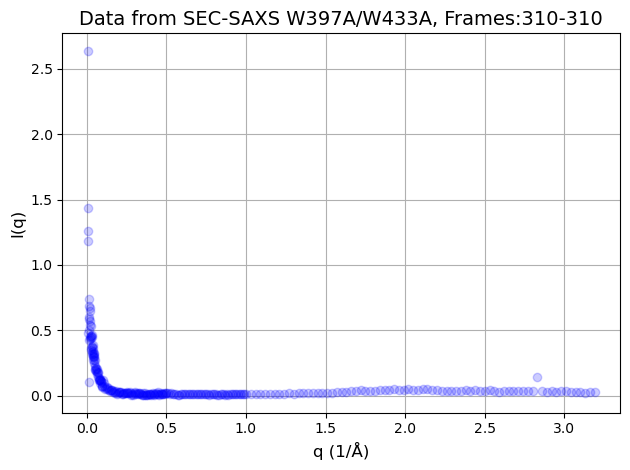

In [25]:
ex_df=dataframes[0]

plt.plot(figsize=(12,6))
title_name=(f"{ex_df.attrs['custom_name']}, Frames:{ex_df.attrs['frames']}")


plt.plot(ex_df['q'], ex_df['I(q)'], marker='o',linestyle='None', alpha=0.2,label='Experimental Data', color='b')

plt.xlabel('q (1/Å)', fontsize=12)
plt.ylabel('I(q)', fontsize=12)
plt.title(f"Data from SEC-SAXS {title_name}", fontsize=14)
plt.grid(True)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

In [8]:
def Ext_Guinier(df, Nres, b_Angstrom, nu_init, Rg_input, q_start_index=0):
    def Rg_nu(b, N, nu):
        g = 1.1615
        return (g * (g + 1) / (2 * (g + 2 * nu) * (g + 2 * nu + 1))) ** 0.5 * b * N ** nu

    def chisq_extguin(parms, q, log_Iq, Nres, b):
        nu = parms[0]
        log_I0 = parms[1]
        Rg = Rg_nu(b, Nres, nu)

        log_Iq_fit = log_I0 - 1 / 3 * q ** 2 * Rg ** 2 + 0.0479 * (nu - 0.212) * q ** 4 * Rg ** 4
        dI = log_Iq_fit - log_Iq
        return np.dot(dI, dI)

    if q_start_index >= len(df):
        return None

    q = df['q'].values
    Iq = df['I(q)'].values
    Rg_init = Rg_nu(b_Angstrom, Nres, 0.6)
    print(f"Rg calculated initial is {Rg_init}")
    
    qcut = 2.0 / Rg_input
    q_lt_cut = q < qcut
    qrange = q[q_lt_cut]
    log_Iq = np.log(Iq[q_lt_cut])
    error_filtered = df['Error'].values[q_lt_cut]

    log_I0_init = log_Iq[0]
    init_parm = [nu_init, log_I0_init]

    opt_parm = optimize.fmin(chisq_extguin, init_parm, args=(qrange, log_Iq, Nres, b_Angstrom), disp=False)
    nu_final, log_I0_final = opt_parm
    Rg_final = Rg_nu(b_Angstrom, Nres, nu_final)

    log_Iq_fit = log_I0_final - 1 / 3 * qrange ** 2 * Rg_final ** 2 + 0.0479 * (nu_final - 0.212) * qrange ** 4 * Rg_final ** 4

    df_cut = df[q_lt_cut].copy()
    df_cut['Ext_Guinier_q_squared'] = qrange ** 2
    df_cut['Ext_Guinier_log_Iq'] = log_Iq
    df_cut['Ext_Guinier_log_Iq_fit'] = log_Iq_fit
    df_cut['Ext_Guinier_delta_Iq']=log_Iq_fit-log_Iq
    df_cut['Ext_Guinier_normalized_delta_Iq']=(log_Iq_fit-log_Iq) / error_filtered

    return df_cut, Rg_final, nu_final


In [12]:
Nres=121
b_Angstrom=5.5
nu_init=0.5
Rg_input=31

ex_df=dataframes[0]
df_cut, Rg_final, nu_final =Ext_Guinier(ex_df, Nres, b_Angstrom, nu_init, Rg_input, q_start_index=0)

print(df_cut.attrs)
print(f"Rg expected is {Rg_input} A^-1. Rg_final calculated by Extended Guinier is {Rg_final} A^-1.")
df_cut

Rg calculated initial is 38.86383092615495
{'file_name': 'AA_0310-0310s', 'custom_name': 'W397A/W433A', 'save_file_name': 'W397A_W433A_SEC-SAXS_frames_310-310', 'frames': '310-310', 'no of frames': 1}
Rg expected is 31 A^-1. Rg_final calculated by Extended Guinier is 46.39438805287191 A^-1.


,q,I(q),Error,Ext_Guinier_q_squared,Ext_Guinier_log_Iq,Ext_Guinier_log_Iq_fit,Ext_Guinier_delta_Iq,Ext_Guinier_normalized_delta_Iq
0,0.006,1.1830,4.16000,0.000036,0.168054,-0.312453,-0.480507,-0.115506
1,0.007,2.6410,1.64100,0.000049,0.971158,-0.321674,-1.292832,-0.787832
2,0.008,1.2610,0.89560,0.000064,0.231905,-0.332274,-0.564179,-0.629946
3,0.009,0.4813,0.61080,0.000081,-0.731265,-0.344236,0.387029,0.633643
4,0.010,1.4380,0.43850,0.000100,0.363253,-0.357538,-0.720792,-1.643767
5,0.011,0.1009,0.35520,0.000121,-2.293625,-0.372161,1.921464,5.409527
6,0.012,0.4282,0.26970,0.000144,-0.848165,-0.388080,0.460085,1.705914
7,0.013,0.5025,0.21530,0.000169,-0.688160,-0.405268,0.282892,1.313942
8,0.014,0.5868,0.18130,0.000196,-0.533071,-0.423696,0.109375,0.603281
9,0.015,0.7404,0.15350,0.000225,-0.300565,-0.443335,-0.142770,-0.930098


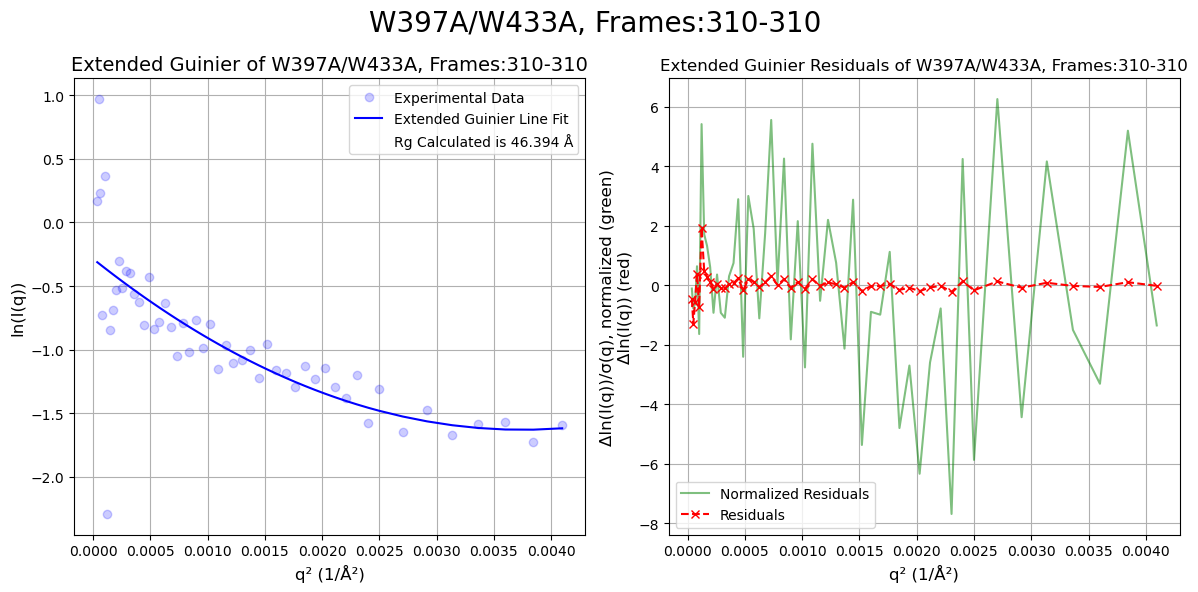

In [18]:
ex_df=df_cut
title_name=(f"{ex_df.attrs['custom_name']}, Frames:{ex_df.attrs['frames']}")


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Subplot 1: q² vs ln(I(q))
# Plot all the experimental data
ax1.plot(ex_df['Ext_Guinier_q_squared'], ex_df['Ext_Guinier_log_Iq'], marker='o',linestyle='None', alpha=0.2,label='Experimental Data', color='b')
ax1.plot(ex_df['Ext_Guinier_q_squared'], ex_df['Ext_Guinier_log_Iq_fit'], linestyle='-', color='b', label='Extended Guinier Line Fit')
ax1.set_xlabel('q² (1/Å²)', fontsize=12)
ax1.set_ylabel('ln(I(q))', fontsize=12)
ax1.set_title(f"Extended Guinier of {title_name}", fontsize=14)
ax1.grid(True)

Rg_final_short=round(Rg_final, 3)
Rg_value = Line2D([0], [0], color='w', label=f'Rg Calculated is {Rg_final_short} Å', linestyle='None')
handles, labels = ax1.get_legend_handles_labels()
handles.append(Rg_value)
ax1.legend(handles=handles)

# Subplot 2: Residuals Δln(I(q))
ax2.plot(ex_df['Ext_Guinier_q_squared'], ex_df['Ext_Guinier_normalized_delta_Iq'], linestyle='-', color='g', alpha=0.5, label='Normalized Residuals')
ax2.plot(ex_df['Ext_Guinier_q_squared'], ex_df['Ext_Guinier_delta_Iq'], marker='x', linestyle='--', color='r', label='Residuals')
ax2.set_xlabel('q² (1/Å²)', fontsize=12)
ax2.set_ylabel('Δln(I(q))/σ(q), normalized (green)\nΔln(I(q)) (red)', fontsize=12)
ax2.set_title(f"Extended Guinier Residuals of {title_name}")
ax2.legend()
ax2.grid(True)

# Adjust layout and display the plots
fig.suptitle(f"{title_name}", fontsize=20)    
save_file_name=df.attrs['save_file_name']

plt.tight_layout()
# plt.savefig(f'Better_Diff_q_start_Good_ExtGuinier_Data_{save_file_name}_with_normalized.png', dpi=600, transparent=True, bbox_inches='tight', pad_inches=0)

plt.show()